In [1]:
import pandas as pd
import numpy as np

listingsDF = pd.read_csv('listings.csv')

calendarDF = pd.read_csv('calendar.csv')

reviewsDF = pd.read_csv('reviews.csv')

In [2]:
#Clean listings

#Instead of dropping we select what we need
listingsDF = listingsDF[['id', 'name','description', 
                         'host_id', 'host_name', 'property_type', 'price', 
                         'number_of_reviews', 'review_scores_rating']]

#We drop all rows with empty cells
listingsDF = listingsDF.dropna(axis=0, how='any')

#Remove the '$' from price
listingsDF.price = listingsDF.price.str.replace('[$]', '')

#Remove the ',' from price
listingsDF.price = listingsDF.price.str.replace(',', '')

#Convert price from object to float
listingsDF['price'] = listingsDF['price'].astype(float)

#listingsDF.head()
listingsDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 9 columns):
id                      3171 non-null int64
name                    3171 non-null object
description             3171 non-null object
host_id                 3171 non-null int64
host_name               3171 non-null object
property_type           3171 non-null object
price                   3171 non-null float64
number_of_reviews       3171 non-null int64
review_scores_rating    3171 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 247.7+ KB


In [3]:
aDF = listingsDF[['name', 'description']]

In [4]:
aDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 2 columns):
name           3171 non-null object
description    3171 non-null object
dtypes: object(2)
memory usage: 74.3+ KB


In [5]:
#Function to clean text

import re 
import string

pd.set_option('display.max_colwidth', -1)

def clean(text):
    text = text.lower()
    text = re.sub('[^\w\s]', '', text) #This removes all the punctuations
    text = re.sub(r'\n',' ', text) #This relaces the \n with space
    text = re.sub(r'\r','', text) #\r
    text = re.sub('[^0-9a-z #+_]', '', text) #Special chars
    
    return text

aDF['description'] = aDF['description'].apply(clean)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
aDF

,name,description
0,Stylish Queen Anne Apartment,make your self at home in this charming onebedroom apartment centrallylocated on the west side of queen anne hill this elegantlydecorated completely private apartment bottom unit of a duplex has an open floor plan bamboo floors a fully equipped kitchen a tv dvd player basic cable and a very cozy bedroom with a queensize bed the unit sleeps up to four two in the bedroom and two on the very comfortable fold out couch linens included and includes free wifi and laundry the apartment opens onto a private deck complete with its own bbq overlooking a garden and a forest of black bamboo the apartment is perfectlylocated just one block from the bus lines where you can catch a bus and be downtown seattle in fifteen minutes or historic ballard in ten or a quick fiveminute walk will bring you to whole foods and peets coffee or take a fifteen minute walk to the top of queen anne hill where you will find a variety of eclectic shops bars and restaurants there is no
1,Bright & Airy Queen Anne Apartment,chemically sensitive weve removed the irritants triggering allergy or asthma attacks like carpeting forced air used pillows all culprits that harbor fungus mold bacteria no smoking no pets designed for healthy living so breathe easy beautiful hypoallergenic apartment in an extremely safe quiet and pedestrianfriendly section of queen anne a leafygreen location that puts the best of seattle at your doorstep free wifi free parking even free pillows whats special about this place hypoallergenic bedding mattressescovers and new pillows with each rental so feel free to take your new pillows with you a beautiful restoration mixing period details modern sensibilities hardwood floors throughout white subway tile lowno vocs nontoxic paints keep this homeawayfromhome clean smart and healthy radiant heat and oil radiators mean no blowing hot air or dust great amenities free wifi internet tv led flatscreen fullyequipped kitchen with st
2,New Modern House-Amazing water view,new modern house built in 2013 spectacular sunsetwater views and light rooftop deck and lounge area hot tub 5 bedrooms gourmet kitchen perfect for 23 families walk to downtown located in highly desirable queen anne neighborhood our house is modern light and fresh with a warm simple palette accented with barnwood steel and concrete open living spaces for entertaining gourmet kitchen deck off the kitchen reading nook half bath and smaller tv room off kitchen fireplace with sofa and sitting area basement room is great for kidsthis room has patio access and a garage door that opens into the space with basketball hoop right outside a queen bedroom and full bath are in the basement with concrete heated floors a queen sleeper sofa is in the tv area in the basement this room has a door if privacy is needed great for a second family with kids the 2nd floor has 4 bedrooms one queen in master one twin bedroom another bedroom has twin bunk beds and the last
4,Charming craftsman 3 bdm house,cozy family craftman house in beautiful neighborhood of queen anne seattle washinton 3 bedrooms can accomodate up to 6 people 1200 sq feet space is your oasis perfect location cozy family craftman house in beautiful neighborhood of queen anne seattle washinton 3 bedrooms can accomodate up to 6 people 1200 sq feet space is your oasis perfect location walking distance to whole foods market a 7 minute drive from the seattle center space needle chihuly garden and glass childrens museum key arena across the street from golf course 2 min walk relax sun bath and watch the ferry boats go by on the large outdoor deck with a view of elliot bay internet cable tv with hbo 3 bedrooms and 2 bathrooms each equipped with a bed for 2 king queen queen washer and dryer in the unit fully stocked kitchen with high end allclad cookware for your peace of mind we have provided a first aid kit and an emergency kit equipped with water and food we are always available
5,Private unit in a 1920s

In [7]:
from sklearn.feature_extraction import text 

#stop_words = text.ENGLISH_STOP_WORDS.union(aStopWords)

#Manually adding words
stop_words = text.ENGLISH_STOP_WORDS.union(["will"])

In [8]:
#Visualize data first?
#Before removing stop words

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Must vectorize before fitting...

vec = CountVectorizer()
doc = vec.fit_transform(aDF['description'])
features = vec.get_feature_names()

#For if we want it in DF 
vm = pd.DataFrame(doc.toarray(), columns=features) 

vis = FreqDistVisualizer(features=features, orient='h', n=20, size=(1000,800)) #n = top n words

vis.fit(doc) 

plt.xlabel("Number of Words", fontsize=15)
plt.ylabel("Words", fontsize=15)
plt.tick_params(labelsize=15)

vis.show()


#########################################

cloud = WordCloud(stopwords='english', background_color="white", max_words=100, max_font_size=120, collocations=False)

text = ' '.join(aDF['description'])
text

wordcloud = cloud.generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


<Figure size 1000x800 with 1 Axes>

<Figure size 800x550 with 1 Axes>

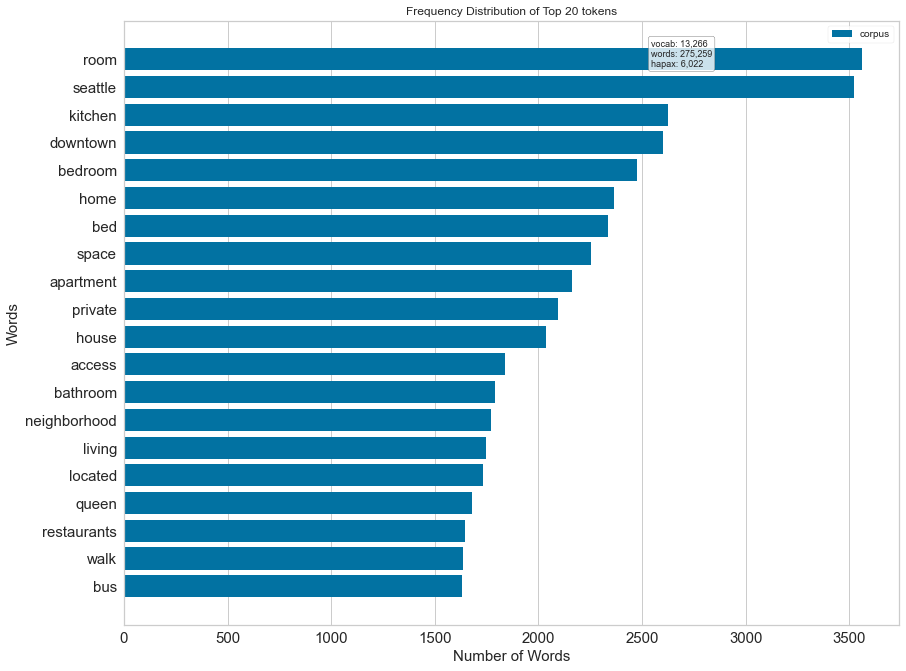

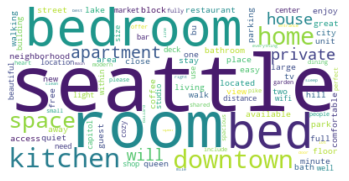

In [9]:
#After removing stop words

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

#Must vectorize before fitting...

vec = CountVectorizer(stop_words=stop_words)
doc = vec.fit_transform(aDF['description'])
features = vec.get_feature_names()

#For if we want it in DF 
vm = pd.DataFrame(doc.toarray(), columns=features) 

vm

#vm = vm.transpose()


vis = FreqDistVisualizer(features=features, orient='h', n=20, size=(1000,800)) #n = top n words

vis.fit(doc) 

plt.xlabel("Number of Words", fontsize=15)
plt.ylabel("Words", fontsize=15)
plt.tick_params(labelsize=15)

vis.show()


#########################################

cloud2 = WordCloud( background_color="white", max_words=100, max_font_size=120, collocations=False) #COLLOCATIONS FALSE!!!!!!!!!

text = ' '.join(aDF['description'])
text

wordcloud2 = cloud2.generate(text)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
aDF['words'] = aDF['description'].apply(lambda x: len(str(x).split())) #length of each description

l = list(aDF['words'])

print("\nMinimum No. of Words in a review: ", min(l),
      "\nMaximum No. of Words in a review: ", max(l), 
      "\nAverage No. of Words:             ", np.average(l))



Minimum No. of Words in a review:  6 
Maximum No. of Words in a review:  202 
Average No. of Words:              154.75685903500474


F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

vm

cos_simi = cosine_similarity(doc) #?? Ignores magnitude | s = cos(angle) = d1.d2 / ||d1|| * || d2|| where (d1.d2 = d1x*d2x + d1y*d2y)

cos_simi

array([[1.        , 0.14537316, 0.20957909, ..., 0.21187202, 0.10200517,
        0.28270889],
       [0.14537316, 1.        , 0.12104107, ..., 0.07586651, 0.05217959,
        0.09400074],
       [0.20957909, 0.12104107, 1.        , ..., 0.24132828, 0.22476613,
        0.2363988 ],
       ...,
       [0.21187202, 0.07586651, 0.24132828, ..., 1.        , 0.10836894,
        0.1762031 ],
       [0.10200517, 0.05217959, 0.22476613, ..., 0.10836894, 1.        ,
        0.22034408],
       [0.28270889, 0.09400074, 0.2363988 , ..., 0.1762031 , 0.22034408,
        1.        ]])

In [12]:
aDF['index'] = aDF.index

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
####################################################

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

test = "i want somewhere quiet and also close to the space needle if not some other tourist spot is ok or shopping malls"

testcorp = [test]

testcorp

##
tfv = TfidfVectorizer()

desc = tfv.fit_transform((aDF['description'])) #fitting and transforming the vector
desc

qq = tfv.transform(testcorp)
qq

##
testcos = map(lambda x: cosine_similarity(qq, x),desc)

wrap = list(testcos)

##
aDF = aDF.reset_index(drop=True)

##
def rec(top, df_all, scores):
    recdf = pd.DataFrame(columns=['name']) 
    count=0
    
    for x in top:
        recdf.at[count,'name']=aDF['name'][x]
        recdf.at[count,'score']=scores[count]
        count+=1
    return recdf

In [91]:
top = sorted(range(len(wrap)), key=lambda i: wrap[i], reverse=True)[:5]
list_scores = [wrap[i][0][0] for i in top]

rec(top,aDF,list_scores)

,name,score
0,Private Room in Belltown,0.201698
1,5 Blocks from Pike Place Market,0.186449
2,Zen space/yoga room warm and modern,0.182524
3,Private room next to Capitol Hill,0.176823
4,Cozy Bedroom near Seattle Center,0.172146


In [92]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 6
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(desc)
NNs = KNN.kneighbors(qq, return_distance=True) 

NNs[0][0][1:]

array([1.27557884, 1.27865217, 1.28310325, 1.28674298, 1.30018366])

In [93]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

rec(top,aDF,index_score)

,name,score
0,5 Blocks from Pike Place Market,1.275579
1,Zen space/yoga room warm and modern,1.278652
2,Private room next to Capitol Hill,1.283103
3,Cozy Bedroom near Seattle Center,1.286743
4,Quiet Nest in Busy Downtown Seattle,1.300184
